# Definice a importy

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

$$\bra{\Psi}\Omega\ket{\Psi}$$


$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\braket{\Psi}{\Psi}$$


$$\braket{\frac{\Psi}{2}}{\Psi}$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib

In [ ]:
plt.rcParams['text.latex.preamble']=r"\usepackage{mlmodern}"
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 11
plt.rcParams["font.family"] = 'mlmodern'
#plt.rcParams["mathtext.fontset"] = "cm"

In [19]:
%set_env QXToken=deleteThisAndPasteYourTokenHere

env: QXToken=deleteThisAndPasteYourTokenHere


In [3]:
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator

Usage: qc.draw('mpl', style = my_style)

In [4]:
my_style = {
"backgroundcolor" : "#111111",
"linecolor" : "#FFFFFF",
"textcolor": "#FFFFFF",
"gatetextcolor": "#FFFFFF" }

In [5]:
import qiskit

qiskit.__version__

'1.1.1'

# VQE

In [46]:
pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
print(np.real(pauli_op.coeffs))
print(pauli_op.paulis)
print(["{}{}".format(i,j) for i,j in zip(np.real(pauli_op.coeffs), pauli_op.paulis)])
for i,j in zip(np.real(pauli_op.coeffs), pauli_op.paulis): print("{}{} ".format(i,j), end='')

[1. 1. 1.]
['ZII', 'IZI', 'IIZ']
['1.0ZII', '1.0IZI', '1.0IIZ']
1.0ZII 1.0IZI 1.0IIZ 

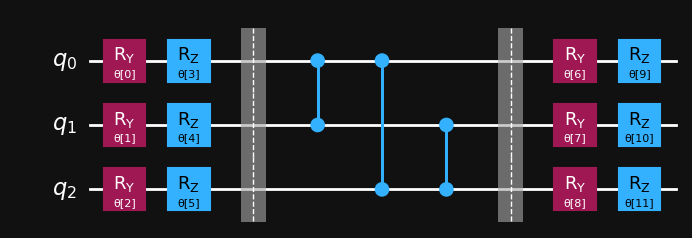

In [47]:
num_qubits = 3
rotation_blocks = ['ry','rz']
entanglement_blocks = 'cz'
entanglement = 'full'

ansatz = TwoLocal(num_qubits, rotation_blocks, entanglement_blocks, entanglement, reps=1, insert_barriers=True)
num_params = ansatz.num_parameters

ansatz.decompose().draw('mpl', style = my_style)

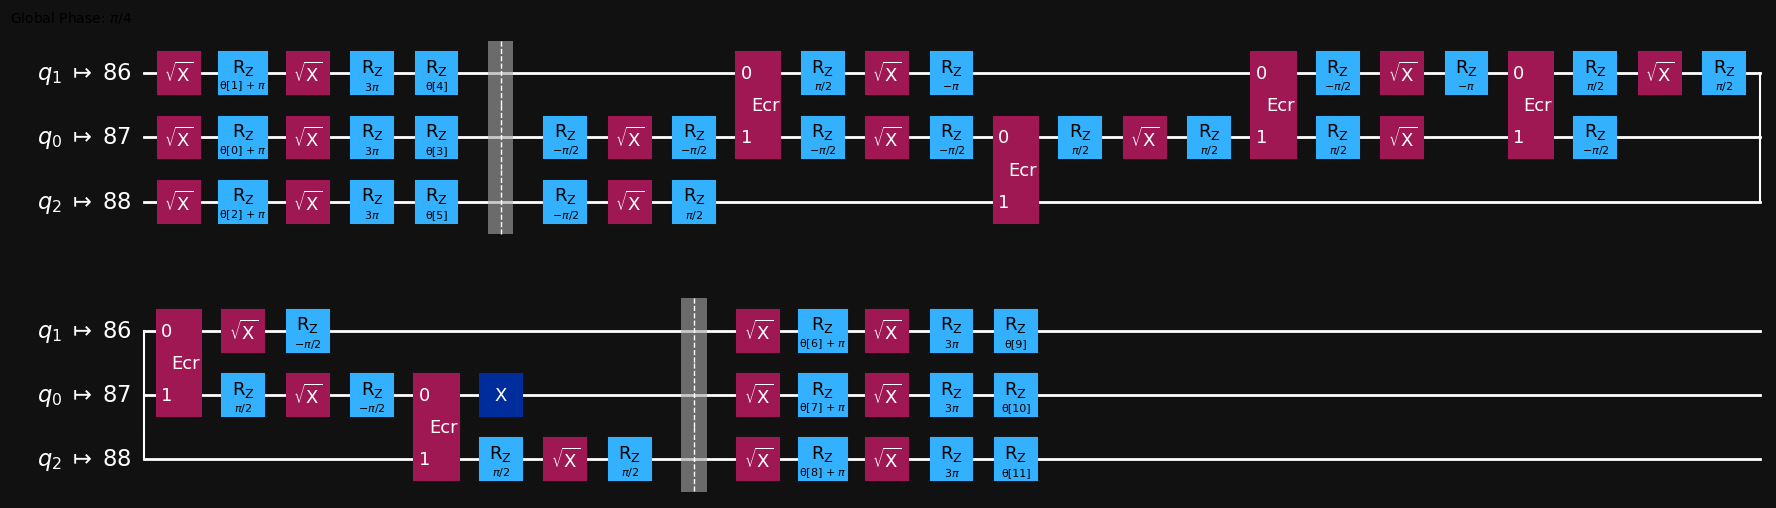

In [48]:
backend_answer = FakeSherbrooke()
optimization_level_answer = 2 
pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)
isa_circuit = pm.run(ansatz) 
isa_circuit.draw('mpl', idle_wires=False, style = my_style)

In [60]:
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)
for i,j in zip(np.real(hamiltonian_isa.coeffs), hamiltonian_isa.paulis): print("{} {} ".format(i,j))

1.0 IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIII... 
1.0 IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIII... 
1.0 IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIII... 


In [61]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(energy)

    print(energy)
    return energy, result

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

x0 = 2 * np.pi * np.random.random(num_params)
x0

array([3.27527604, 3.33932874, 3.27653615, 2.13682587, 2.91975106,
       2.88752643, 3.9709026 , 4.35967314, 4.27707391, 1.50168501,
       5.84711418, 6.12923122])

In [70]:
backend = FakeSherbrooke()
# backend = AerSimulator()

def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)

    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method="cobyla",
        options={'maxiter': 1000})

1.744140625
1.47119140625
1.27587890625
0.93701171875
0.9462890625
0.8564453125
0.861328125
0.4951171875
0.1650390625
-0.23828125
-0.22998046875
-0.2783203125
-0.25537109375
-0.15966796875
-0.2294921875
-0.54638671875
-1.7724609375
-2.47216796875
-2.6083984375
-2.59423828125
-2.0283203125
-2.59228515625
-1.587890625
-2.64599609375
-2.3291015625
-2.33203125
-2.6337890625
-2.6669921875
-2.6025390625
-2.63427734375
-2.6484375
-2.58935546875
-2.15966796875
-2.6787109375
-2.72119140625
-2.78173828125
-2.8076171875
-2.7978515625
-2.84912109375
-2.71826171875
-2.82275390625
-2.79638671875
-2.8466796875
-2.75
-2.85693359375
-2.74853515625
-2.82666015625
-2.78662109375
-2.82421875
-2.84130859375
-2.8271484375
-2.85595703125
-2.82861328125
-2.83642578125
-2.83642578125
-2.8466796875
-2.8447265625
-2.8447265625
-2.84375
-2.8310546875
-2.861328125
-2.8515625
-2.8583984375
-2.86083984375
-2.87841796875
-2.8623046875
-2.86767578125
-2.8740234375
-2.8564453125
-2.85009765625
-2.86279296875
-2.8461914

In [69]:
backend = FakeSherbrooke()
# backend = AerSimulator()

def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

aer = AerSimulator.from_backend(backend)
estimator = Estimator(mode=aer)

res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
        method="Nelder-Mead",
        options={'maxiter': 1000})

1.71826171875
1.755859375
1.83056640625
1.83984375
1.6884765625
1.76171875
1.7265625
1.58447265625
1.505859375
1.55810546875
1.693359375
1.708984375
1.7236328125
1.5224609375
1.4912109375
1.2783203125
1.56591796875
1.4326171875
1.4619140625
1.3955078125
1.35498046875
1.306640625
1.2548828125
0.9609375
1.06494140625
1.18408203125
1.1279296875
1.107421875
0.95849609375
0.67578125
0.873046875
0.77587890625
0.75927734375
0.69091796875
0.59033203125
0.15478515625
0.44873046875
0.33349609375
0.341796875
0.2578125
0.17431640625
0.00927734375
-0.4443359375
-0.10205078125
-0.10546875
-0.2373046875
-0.37109375
-0.3876953125
-0.59619140625
-1.01416015625
-0.6572265625
-0.642578125
-0.75048828125
-0.8515625
-0.763671875
-0.978515625
-0.97509765625
-1.04443359375
-1.11181640625
-0.986328125
-0.95361328125
-0.90625
-0.93115234375
-1.0341796875
-0.57275390625
-0.96484375
-1.0439453125
-1.240234375
-1.32177734375
-0.9208984375
-1.2890625
-0.90625
-1.06640625
-1.17138671875
-1.3173828125
-1.09716796875

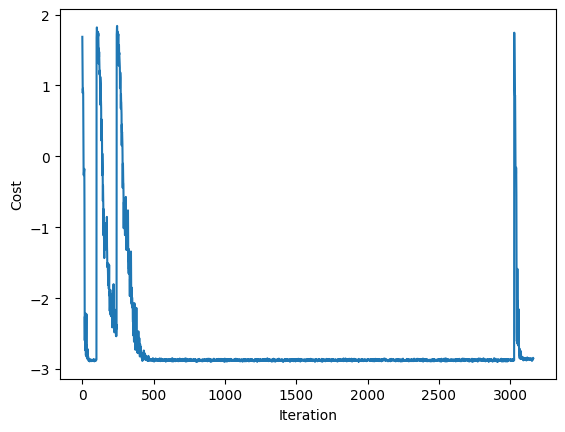

In [71]:
fig, ax = plt.subplots()
plt.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.draw()